# Import Needed Libraries

In [1]:
import re
import os
import cv2
import html
from keras.layers.merge import add, concatenate
import string
import datetime
import string
import unicodedata
import editdistance
import numpy as np
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Activation
import os
import logging
import matplotlib.pyplot as plt
try:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
    logging.disable(logging.WARNING)
except AttributeError:
    pass
import tensorflow as tf

from contextlib import redirect_stdout
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Model
import unicodedata
from itertools import groupby
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.layers import Input, Add, Activation, Lambda, MaxPooling2D, Reshape
import h5py
import random
import multiprocessing
import xml.etree.ElementTree as ET
import pandas as pd
from glob import glob
from tqdm import tqdm
from functools import partial
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive', True)

Mounted at /content/drive


# Preprocessing

In [2]:
def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs

def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    imgs = np.expand_dims(imgs / 255, axis=-1)
    return imgs

In [3]:
class preprocessing():

  def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs
  

  def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    imgs = np.expand_dims(imgs / 255, axis=-1)
    return imgs
  
  def preprocess(img, input_size):
    """Make the process with the `input_size` to the scale resize"""

    def imread(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        u, i = np.unique(np.array(img).flatten(), return_inverse=True)
        background = int(u[np.argmax(np.bincount(i))])
        return img, background

    if isinstance(img, str):
        img, bg = imread(img)

    if isinstance(img, tuple):
        image, boundbox = img
        img, bg = imread(image)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])
            else:
                boundbox[i] = int(boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
    img = cv2.resize(img, new_size)

    target = np.ones([ht, wt], dtype=np.uint8) * bg
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)

    return img


# HDF5 Dataset

In [ ]:
class Dataset():

  def __init__(self, path, image_size, batch_size, target_path = '/content/drive/MyDrive/Files_ArabicTextRecognition'):
    self.preprocessing = preprocessing()
    self.path  =path
    self.image_size = image_size
    self.batch_size = batch_size
    self.target_path = target_path
    self.partitions = ['train', 'valid', 'test']
    self.dataset = {}
    for k in self.partitions:
      self.dataset[k] = {"dt": [], "gt": []}
    self.fill_dataset()
    print(len(self.dataset['train']['dt']), len(self.dataset['train']['gt']))
    print(len(self.dataset['valid']['dt']), len(self.dataset['valid']['gt']))
    print(len(self.dataset['test']['dt']), len(self.dataset['test']['gt']))
    self.hdf5_file()

  def fill_dataset(self):
    train_images_path = self.path['train_images']
    train_images = sorted([os.path.join(train_images_path, file)for file in os.listdir(train_images_path)])
    train_labels_path = self.path['train_labels']
    train_labels = sorted(os.listdir(train_labels_path))
    valid_images_path = self.path['valid_images']
    valid_images = sorted([os.path.join(valid_images_path, file)for file in os.listdir(valid_images_path)])
    valid_labels_path = self.path['valid_labels']
    valid_labels = sorted(os.listdir(valid_labels_path))
    test_images_path = self.path['test_images']
    test_images = sorted([os.path.join(test_images_path, file)for file in os.listdir(test_images_path)])
    test_labels_path = self.path['test_labels']
    test_labels = sorted(os.listdir(test_labels_path))
    for img in train_images:
      self.dataset['train']['dt'].append(img)
    train_labels = self.extract_labels(train_labels_path, train_labels)
    self.dataset['train']['gt'] = train_labels
    for img in valid_images:
      self.dataset['valid']['dt'].append(img)
    valid_labels = self.extract_labels(valid_labels_path, valid_labels)
    self.dataset['valid']['gt'] = valid_labels
    for img in test_images:
      self.dataset['test']['dt'].append(img)
    test_labels = self.extract_labels(test_labels_path, test_labels)
    self.dataset['test']['gt'] = test_labels
    train_characters = set(char for label in train_labels for char in label)
    valid_characters = set(char for label in valid_labels for char in label)
    test_characters = set(char for label in test_labels for char in label)
    self.characters = {i for j in (train_characters, valid_characters, test_characters) for i in j}
    train_max_length = max([len(label) for label in train_labels])
    valid_max_length = max([len(label) for label in valid_labels])
    test_max_length = max([len(label) for label in test_labels])
    self.max_length = max(train_max_length, valid_max_length, test_max_length)
 
  def extract_labels(self,path, files):
    length = len(files)
    Y = []
    for i in range(length):
      f = path + '/'+ files[i]
      with open(f,  encoding='windows-1256') as file:
        text = file.read()
        Y.append(text)
      file.close()
    return Y

  def get_lengthAndCharset(self):
    return self.max_length, self.characters

  def hdf5_file(self):
    target = os.path.join(self.target_path, "data2.hdf5")
    print(target)
    total = 0
    with h5py.File(target, "w") as hf:
      for pt in self.partitions:
        #self.dataset[pt] = self.check_text(self.dataset[pt])
        size = (len(self.dataset[pt]['dt']),) + self.image_size[:2]
        total += size[0]
        dummy_image = np.zeros(size, dtype=np.uint8)
        dummy_sentence = [("c" * self.max_length).encode()] * size[0]

        hf.create_dataset(f"{pt}/dt", data=dummy_image, compression="gzip", compression_opts=9)
        hf.create_dataset(f"{pt}/gt", data=dummy_sentence, compression="gzip", compression_opts=9)
    pbar = tqdm(total=total)
    print(total)
    for pt in self.partitions:
      for batch in range(0, len(self.dataset[pt]['gt']), self.batch_size):
        images = []
        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
          r = pool.map(partial(preprocessing.preprocess, input_size=self.image_size), self.dataset[pt]['dt'][batch:batch + self.batch_size])
          images.append(r)
          pool.close()
          pool.join()

        with h5py.File(target, "a") as hf:
          hf[f"{pt}/dt"][batch:batch + self.batch_size] = images
          hf[f"{pt}/gt"][batch:batch + self.batch_size] = [s.encode('utf-8') for s in self.dataset[pt]['gt'][batch:batch + self.batch_size]]
          pbar.update(self.batch_size)


  def check_text(self, data):
    for i in reversed(range(len(data['gt']))):
      text = text_standardize(data['gt'][i])
      strip_punc = text.strip(string.punctuation).strip()
      no_punc = text.translate(str.maketrans("", "", string.punctuation)).strip()
      length_valid = (len(text) > 1) and (len(text) < self.max_length)
      text_valid = (len(strip_punc) > 1) or (len(no_punc) > 1)
      if (not length_valid) or (not text_valid):
        data['gt'].pop(i)
        data['dt'].pop(i)
        continue
    return data

# Tokenizer

In [ ]:
class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length):
        self.PAD_TK, self.UNK_TK = "¶", "¤"
        self.chars = chars
        self.chars.append(self.PAD_TK)
        self.chars.append(self.UNK_TK)

        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        if isinstance(text, bytes):
            text = text.decode(encoding = "UTF-8")

        #text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        #text = " ".join(text.split())

        #groups = ["".join(group) for _, group in groupby(text)]
        #text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        
        encoded = []

        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""

        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")

# Data Generator

In [ ]:
class DataGenerator():

    def __init__(self, source, batch_size, charset, max_length, predict=False, stream=False):
        self.preprocessing = preprocessing()
        self.source = source
        self.batch_size = batch_size
        self.tokenizer = Tokenizer(charset, max_length)
        self.batch_size = batch_size
        self.size = dict()
        self.steps = dict()
        self.index = dict()

        if stream:
            self.dataset = h5py.File(source, "r")

            for pt in ['train', 'valid', 'test']:
                self.size[pt] = self.dataset[pt]['gt'][:].shape[0]
                self.steps[pt] = int(np.ceil(self.size[pt] / self.batch_size))
        else:
            self.dataset = dict()

            with h5py.File(source, "r") as f:
                for pt in ['train', 'valid', 'test']:
                    self.dataset[pt] = dict()
                    self.dataset[pt]['dt'] = np.array(f[pt]['dt'])
                    self.dataset[pt]['gt'] = np.array(f[pt]['gt'])
                    for i in range(len(self.dataset[pt]['gt'])):
                      if (len(self.dataset[pt]['gt'][i]) >= 132 and (bytes([self.dataset[pt]['gt'][i][131]]) == b'\xd8'
                        or bytes([self.dataset[pt]['gt'][i][131]]) == b'\xd9' or bytes([self.dataset[pt]['gt'][i][131]]) == b'\xc2')):
                          self.dataset[pt]['gt'][i] = self.dataset[pt]['gt'][i][:131]

                    self.size[pt] = len(self.dataset[pt]['gt'])
                    self.steps[pt] = int(np.ceil(self.size[pt] / self.batch_size))

        self.stream = stream
        self.arange = np.arange(len(self.dataset['train']['gt']))
        np.random.seed(42)

    def next_train_batch(self):
        """Get the next batch from train partition (yield)"""

        self.index['train'] = 0

        while True:
            if self.index['train'] >= self.size['train']:
                self.index['train'] = 0

                if not self.stream:
                    np.random.shuffle(self.arange)
                    self.dataset['train']['dt'] = self.dataset['train']['dt'][self.arange]
                    self.dataset['train']['gt'] = self.dataset['train']['gt'][self.arange]

            index = self.index['train']
            until = index + self.batch_size
            self.index['train'] = until

            x_train = self.dataset['train']['dt'][index:until]
            x_train = augmentation(x_train,
                                      rotation_range=1.5,
                                      scale_range=0.05,
                                      height_shift_range=0.025,
                                      width_shift_range=0.05,
                                      erode_range=5,
                                      dilate_range=3)
            x_train = normalization(x_train)
            y_train = [self.tokenizer.encode(y) for y in self.dataset['train']['gt'][index:until]]
            y_train = [np.pad(y, (0, self.tokenizer.maxlen - len(y))) for y in y_train]
            y_train = np.asarray(y_train, dtype=np.int16)

            yield (x_train, y_train)

    def next_valid_batch(self):
        """Get the next batch from validation partition (yield)"""

        self.index['valid'] = 0

        while True:
            if self.index['valid'] >= self.size['valid']:
                self.index['valid'] = 0

            index = self.index['valid']
            until = index + self.batch_size
            self.index['valid'] = until

            x_valid = self.dataset['valid']['dt'][index:until]
            x_valid = normalization(x_valid)

            y_valid = [self.tokenizer.encode(y) for y in self.dataset['valid']['gt'][index:until]]
            y_valid = [np.pad(y, (0, self.tokenizer.maxlen - len(y))) for y in y_valid]
            y_valid = np.asarray(y_valid, dtype=np.int16)

            yield (x_valid, y_valid)

    def next_test_batch(self):
        """Return model predict parameters"""

        self.index['test'] = 0

        while True:
            if self.index['test'] >= self.size['test']:
                self.index['test'] = 0
                break

            index = self.index['test']
            until = index + self.batch_size
            self.index['test'] = until

            x_test = self.dataset['test']['dt'][index:until]
            x_test = normalization(x_test)

            yield x_test


# Flor Model

In [ ]:
class FullGatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(FullGatedConv2D, self).call(inputs)
        linear = Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = Activation("sigmoid")(output[:, :, :, self.nb_filters:])

        return Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        """Compute shape of layer output"""

        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        """Return the config of the layer"""

        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Custom schedule of the learning rate with warmup_steps.
    From original paper "Attention is all you need".
    """

    def __init__(self, d_model, initial_step=0, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, dtype="float32")
        self.initial_step = initial_step
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step + self.initial_step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
class HTRModel:

    def __init__(self,
                 architecture,
                 input_size,
                 vocab_size,
                 greedy=False,
                 beam_width=10,
                 top_paths=1,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 cooldown=0):
        """
        Initialization of a HTR Model.
        :param
            architecture: option of the architecture model to build and compile
            greedy, beam_width, top_paths: Parameters of the CTC decoding
            (see ctc decoding tensorflow for more details)
        """

        self.architecture = globals()[architecture]
        self.input_size = input_size
        self.vocab_size = vocab_size

        self.model = None
        self.greedy = greedy
        self.beam_width = beam_width
        self.top_paths = max(1, top_paths)

        self.stop_tolerance = stop_tolerance
        self.reduce_tolerance = reduce_tolerance
        self.cooldown = cooldown

    def summary(self, output=None, target=None):
        """Show/Save model structure (summary)"""

        self.model.summary()

        if target is not None:
            os.makedirs(output, exist_ok=True)

            with open(os.path.join(output,"/", target), "w") as f:
                with redirect_stdout(f):
                    self.model.summary()

    def plot_model(self):
      plot_model(self.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    def load_checkpoint(self, target):
        """ Load a model with checkpoint file"""

        if os.path.isfile(target):
            if self.model is None:
                self.compile()

            self.model.load_weights(target)

    def get_callbacks(self, logdir, checkpoint, monitor="val_loss", verbose=0):
        """Setup the list of callbacks for the model"""

        callbacks = [
            CSVLogger(
                filename=os.path.join(logdir, "/epochs.log"),
                separator=";",
                append=True),
            TensorBoard(
                log_dir=logdir,
                histogram_freq=10,
                profile_batch=0,
                write_graph=True,
                write_images=False,
                update_freq="epoch"),
            ModelCheckpoint(
                filepath=checkpoint,
                monitor=monitor,
                save_best_only=True,
                save_weights_only=True,
                verbose=verbose),
            EarlyStopping(
                monitor=monitor,
                min_delta=1e-8,
                patience=self.stop_tolerance,
                restore_best_weights=True,
                verbose=verbose),
            ReduceLROnPlateau(
                monitor=monitor,
                min_delta=1e-8,
                factor=0.2,
                patience=self.reduce_tolerance,
                cooldown=self.cooldown,
                verbose=verbose)
        ]

        return callbacks

    def compile(self, learning_rate=None, initial_step=0):
        """
        Configures the HTR Model for training/predict.
        :param optimizer: optimizer for training
        """

        # define inputs, outputs and optimizer of the chosen architecture
        inputs, outputs = self.architecture(self.input_size, self.vocab_size + 1)

        if learning_rate is None:
            learning_rate = CustomSchedule(d_model=self.vocab_size + 1, initial_step=initial_step)
            self.learning_schedule = True
        else:
            self.learning_schedule = False

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        # create and compile
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=self.ctc_loss_lambda_func)

    def fit(self,
            x=None,
            y=None,
            batch_size=None,
            epochs=1,
            verbose=1,
            callbacks=None,
            validation_split=0.0,
            validation_data=None,
            shuffle=True,
            class_weight=None,
            sample_weight=None,
            initial_epoch=0,
            steps_per_epoch=None,
            validation_steps=None,
            validation_freq=1,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False,
            **kwargs):
        """
        Model training on data yielded (fit function has support to generator).
        A fit() abstration function of TensorFlow 2.
        Provide x parameter of the form: yielding (x, y, sample_weight).
        :param: See tensorflow.keras.Model.fit()
        :return: A history object
        """

        # remove ReduceLROnPlateau (if exist) when use schedule learning rate
        if callbacks and self.learning_schedule:
            callbacks = [x for x in callbacks if not isinstance(x, ReduceLROnPlateau)]

        out = self.model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                             callbacks=callbacks, validation_split=validation_split,
                             validation_data=validation_data, shuffle=shuffle,
                             class_weight=class_weight, sample_weight=sample_weight,
                             initial_epoch=initial_epoch, steps_per_epoch=steps_per_epoch,
                             validation_steps=validation_steps, validation_freq=validation_freq,
                             max_queue_size=max_queue_size, workers=workers,
                             use_multiprocessing=use_multiprocessing, **kwargs)
        return out

    def predict(self,
                x,
                batch_size=None,
                verbose=0,
                steps=1,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                ctc_decode=True):
        """
        Model predicting on data yielded (predict function has support to generator).
        A predict() abstration function of TensorFlow 2.
        Provide x parameter of the form: yielding [x].
        :param: See tensorflow.keras.Model.predict()
        :return: raw data on `ctc_decode=False` or CTC decode on `ctc_decode=True` (both with probabilities)
        """

        if verbose == 1:
            print("Model Predict")

        out = self.model.predict(x=x, batch_size=batch_size, verbose=verbose, steps=steps,
                                 callbacks=callbacks, max_queue_size=max_queue_size,
                                 workers=workers, use_multiprocessing=use_multiprocessing)

        if not ctc_decode:
            return np.log(out.clip(min=1e-8)), []

        steps_done = 0
        if verbose == 1:
            print("CTC Decode")
            progbar = tf.keras.utils.Progbar(target=steps)

        batch_size = int(np.ceil(len(out) / steps))
        input_length = len(max(out, key=len))

        predicts, probabilities = [], []

        while steps_done < steps:
            index = steps_done * batch_size
            until = index + batch_size

            x_test = np.asarray(out[index:until])
            x_test_len = np.asarray([input_length for _ in range(len(x_test))])

            decode, log = K.ctc_decode(x_test,
                                       x_test_len,
                                       greedy=self.greedy,
                                       beam_width=self.beam_width,
                                       top_paths=self.top_paths)

            probabilities.extend([np.exp(x) for x in log])
            decode = [[[int(p) for p in x if p != -1] for x in y] for y in decode]
            predicts.extend(np.swapaxes(decode, 0, 1))

            steps_done += 1
            if verbose == 1:
                progbar.update(steps_done)

        return (predicts, probabilities)

    @staticmethod
    def ctc_loss_lambda_func(y_true, y_pred):
        """Function for computing the CTC loss"""

        if len(y_true.shape) > 2:
            y_true = tf.squeeze(y_true)

        # y_pred.shape = (batch_size, string_length, alphabet_size_1_hot_encoded)
        # output of every model is softmax
        # so sum across alphabet_size_1_hot_encoded give 1
        #               string_length give string length
        input_length = tf.math.reduce_sum(y_pred, axis=-1, keepdims=False)
        input_length = tf.math.reduce_sum(input_length, axis=-1, keepdims=True)

        # y_true strings are padded with 0
        # so sum of non-zero gives number of characters in this string
        label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True, dtype="int64")

        loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

        # average loss across all entries in the batch
        loss = tf.reduce_mean(loss)

        return loss

In [ ]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
def flor(input_size, d_model):
    """
    Gated Convolucional Recurrent Neural Network by Flor et al.
    """

    input_data = Input(name="input", shape=input_size)

    x = Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_data)
    x = MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)

    #Third conv block
    x = Conv2D(128,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv3")(x)
    x = MaxPooling2D((2, 2), name="pool3")(x)

    shape = ((128), (16) * 128)
    new_shape = shape
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(256, activation="relu", name="dense1")(x)
    x = Dropout(0.6)(x)
    # RNNs
    lstm_1 = GRU(128, return_sequences=True, name = "GRU_1a")(x)
    lstm_1b = GRU(128, return_sequences=True,go_backwards=True, name = "GRU_1b")(x)
    lstm_merged_1 = Add(name = "merge1")([lstm_1, lstm_1b])
    lstm_2 = GRU(128, return_sequences=True, name = "GRU_2a")(lstm_merged_1)
    lstm_2b = GRU(128, return_sequences=True,go_backwards=True, name = "GRU_2b")(lstm_merged_1)
    x = concatenate([lstm_2, lstm_2b], name ="concatenate")
    # Output layer
    output_data = Dense(units=d_model, activation="softmax", name="Output")(x)

    return (input_data, output_data)

# Run HDF5 Section

In [ ]:
path = {}
path['train_images'] = '/content/drive/MyDrive/Files_ArabicTextRecognition/Dataset/UniqueImages/Train'
path['valid_images'] = '/content/drive/MyDrive/Files_ArabicTextRecognition/Dataset/UniqueImages/Validate'
path['test_images'] = '/content/drive/MyDrive/Files_ArabicTextRecognition/Dataset/UniqueImages/Test'
path['train_labels'] = '/content/drive/MyDrive/Files_ArabicTextRecognition/Dataset/UniqueTextUnicodeTruthValues-v1.0/Training'
path['valid_labels'] = '/content/drive/MyDrive/Files_ArabicTextRecognition/Dataset/UniqueTextUnicodeTruthValues-v1.0/Validation'
path['test_labels'] = '/content/drive/MyDrive/Files_ArabicTextRecognition/Dataset/UniqueTextUnicodeTruthValues-v1.0/Testing'
dataset = Dataset(path= path, image_size= (1024, 128, 1), batch_size= 512)
max_length, charset = dataset.get_lengthAndCharset()
print(max_length)
print(charset)
print(len(charset))

4837 4837
939 939
960 960
/content/drive/MyDrive/Files_ArabicTextRecognition/data2.hdf5







  0%|          | 0/6736 [00:00<?, ?it/s]

6736







  8%|▊         | 512/6736 [00:13<02:46, 37.46it/s]




  8%|▊         | 512/6736 [00:31<02:46, 37.46it/s]




 15%|█▌        | 1024/6736 [00:31<02:47, 34.15it/s]




 23%|██▎       | 1536/6736 [00:48<02:36, 33.29it/s]




 23%|██▎       | 1536/6736 [00:48<02:36, 33.29it/s]




 30%|███       | 2048/6736 [01:02<02:17, 34.04it/s]




 30%|███       | 2048/6736 [01:02<02:17, 34.04it/s]




 30%|███       | 2048/6736 [01:20<02:17, 34.04it/s]




 38%|███▊      | 2560/6736 [01:20<02:10, 32.10it/s]




 46%|████▌     | 3072/6736 [01:36<01:55, 31.79it/s]




 46%|████▌     | 3072/6736 [01:36<01:55, 31.79it/s]




 46%|████▌     | 3072/6736 [01:51<01:55, 31.79it/s]




 53%|█████▎    | 3584/6736 [01:51<01:36, 32.72it/s]




 53%|█████▎    | 3584/6736 [02:09<01:36, 32.72it/s]




 61%|██████    | 4096/6736 [02:09<01:25, 30.99it/s]




 61%|██████    | 4096/6736 [02:26<01:25, 30.99it/s]




 68%|██████▊   | 4608/6736 [02:26<01:08, 31.01it/s]




 76%|███████▌  | 5120/6736 [02:33<00:43, 37.1

132
{'ط', '(', '\\', '#', '=', 'ل', '1', ';', 'ى', '/', 'ٌ', '‘', 'ت', 'ئ', 'أ', 'ّ', '\xa0', '3', 'ي', 'ع', ')', 'ٍ', 'ف', 'س', '6', '*', 'ص', 'ء', ',', 'ه', '7', 'غ', 'د', '[', 'و', ':', '+', 'ـ', '?', 'ظ', '؛', '!', 'ْ', 'ض', '.', 'ق', '-', 'ك', '%', 'م', 'ز', '،', ' ', '؟', 'ن', '2', 'ج', '"', '×', '5', 'ِ', 'آ', ']', '>', 'x', 'ر', 'إ', '0', 'ب', '8', 'ذ', 'ة', 'ُ', 'ث', 'ؤ', 'خ', 'َ', '9', '–', 'ش', 'ح', '4', 'ا', 'ً'}
84


# Train & Test

In [ ]:
image_size = (1024, 128, 1) 
arch = "flor"
max_length = 132
charset = list(['ط', '(', '\\', '#', '=', 'ل', '1', ';', '\xa0', 'ى', '/', 'ٌ', '‘', 'ت', 'ئ', 'أ', 'ّ', '3', 'ي', 'ع', ')', 'ٍ', 'ف', 'س', '6', '*', 'ص', 'ء', ',', 'ه', '7', 'غ', 'د', '[', 'و', ':', '+', 'ـ', '?', 'ظ', '؛', '!', 'ْ', 'ض', '.', 'ق', '-', 'ك', '%', 'م', 'ز', '،', ' ', '؟', 'ن', '2', 'ج', '"', '×', '5', 'ِ', 'آ', ']', '>', 'x', 'ر', 'إ', '0', 'ب',
                '8', 'ذ', 'ة', 'ُ', 'ث', 'ؤ', 'خ', 'َ', '9', '–', 'ش', 'ح', '4', 'ا', 'ً'])
batch_size = 16
source = os.path.join("/content/drive/MyDrive/Files_ArabicTextRecognition", "data2.hdf5")
output_path = os.path.join("/content/drive/MyDrive/Files_ArabicTextRecognition", "output", arch+"+THP+3")
target_path = os.path.join(output_path, "checkpoint_weights_model_THP_3.hdf5")
dtgen = DataGenerator(source=source, batch_size=batch_size, charset=charset, max_length=max_length)

In [ ]:
print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 4837
Validation images: 939
Test images: 960


In [ ]:
model = HTRModel(architecture=arch,input_size=image_size,vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,stop_tolerance=10,reduce_tolerance=5)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)
callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1024, 128, 1 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 1024, 128, 32 320         input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 512, 64, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 512, 64, 64)  18496       pool1[0][0]                      
___________________________________________________________________________________________

In [ ]:
model.plot_model()

In [ ]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),epochs=100,steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/100
303/303 [==============================] - 44s 128ms/step - loss: 198.2387 - val_loss: 194.4708

Epoch 00001: val_loss improved from inf to 194.47084, saving model to /content/drive/MyDrive/Files_ArabicTextRecognition/output/flor+THP+4/checkpoint_weights_model_THP_4.hdf5
Epoch 2/100
303/303 [==============================] - 37s 121ms/step - loss: 188.1884 - val_loss: 181.2396

Epoch 00002: val_loss improved from 194.47084 to 181.23964, saving model to /content/drive/MyDrive/Files_ArabicTextRecognition/output/flor+THP+4/checkpoint_weights_model_THP_4.hdf5
Epoch 3/100
303/303 [==============================] - 37s 121ms/step - loss: 177.7035 - val_loss: 178.2538

Epoch 00003: val_loss improved from 181.23964 to 178.25378, saving model to /content/drive/MyDrive/Files_ArabicTextRecognition/output/flor+THP+4/checkpoint_weights_model_THP_4.hdf5
Epoch 4/100
303/303 [==============================] - 37s 123ms/step - loss: 175.4441 - val_loss: 175.9966

Epoch 00004: val_loss impro

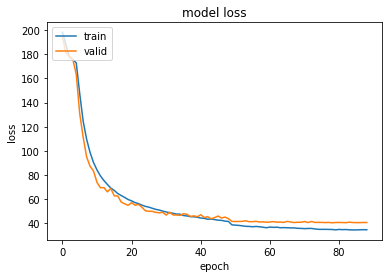

In [ ]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Prediction

In [ ]:
def adjust_to_see(img):
    """Rotate and transpose to image visualize (cv2 method or jupyter notebook)"""

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))

    return img

Model Predict
60/60 [==============================] - 3s 32ms/step
CTC Decode
 1/60 [..............................] - ETA: 1:00

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


60/60 [==============================] - 62s 1s/step



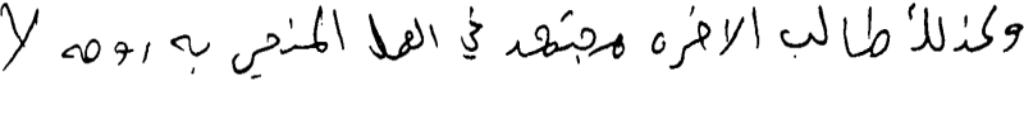

TE_L: وكذلك طالب الآخره مجتهد في العمل المنجي به روحه لا
TE_P: وكذلك طالب الاخره مجتهد في العل المنحي به رومه لا 




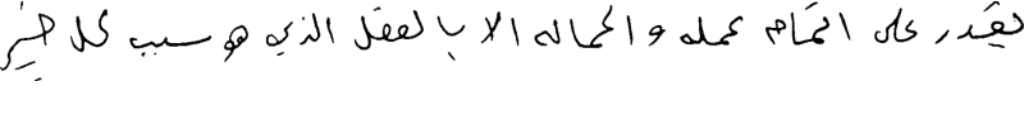

TE_L: يقدر على اتمام عمله و اكماله إلا بالعقل الذي هو سبب كل خير
TE_P: لقدر على انمام عمله والماله الاب لعقل الذي هو سب كل جي 




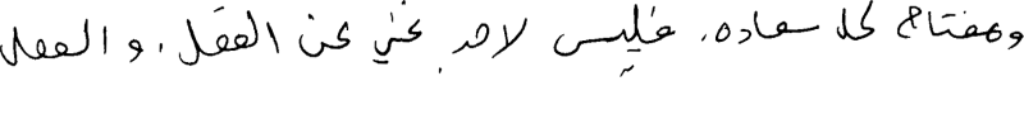

TE_L: ومفتاح كل سعادهِ. فليس لأحد غني عن العقل . والعقل
TE_P: ومفتاط كلى سعاده . فلي لاحد غي من الفقل. والعل 




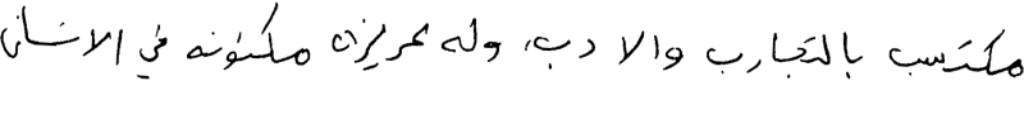

TE_L: مكتسب بالتجارب والأدب. وله غريزةٌ مكنونةٌ في الانسان
TE_P: مكتسب بالتجارب والادب وله مريزان مكنونه في الانسان 




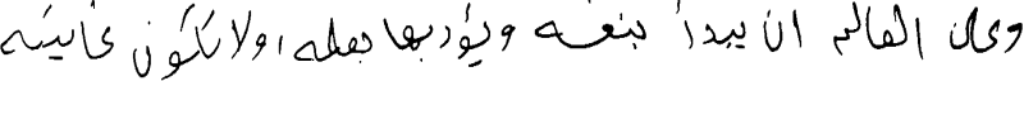

TE_L: وعلى العالم ان يبدأ بنفسه ويؤدبها بعلمه، ولا تكون غايته
TE_P: وعلن العالم الن يداأ بنفه ويؤدبها عله ، ولا تكون غايئ 




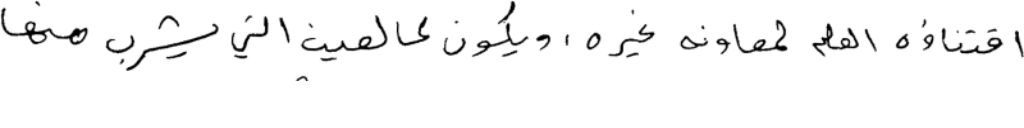

TE_L: اقتناؤه العلم لمعاونه غيره، ويكون كالعين التي يشرب منها
TE_P: اقتنافه العلم معاونه غيره ، ويكون مالفين التي شرب منه 




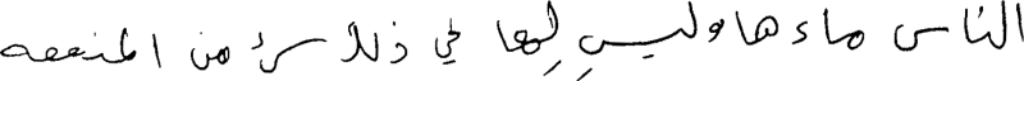

TE_L: الناس ماءها وليس لها في ذلك شيءَ من المنفعه،
TE_P: الناس ماءها وليه لها في ذلكسك من المنع 




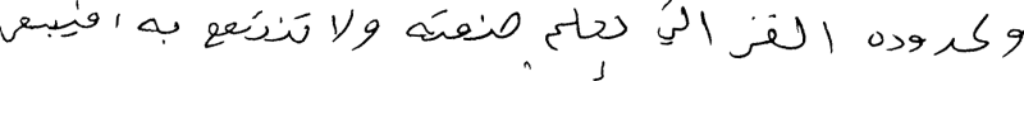

TE_L: وكدوده القز التي تحكم صنعته ولا تنتفع به . فينبغي
TE_P: وكدوده الغر التي تعلم حنفته ولا تنتع به ، فيع 




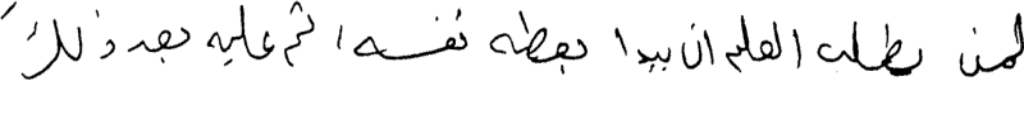

TE_L: لمن يطلب العلم ان يبدأ بعظه نفسه، ثم عليه بعد ذلك
TE_P: لمن بطلب العلم ان بدا بعطه نفسه، ثم عليه دعد ذلك 




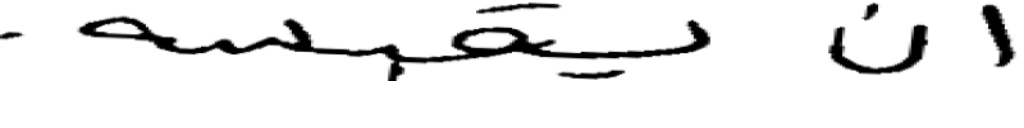

TE_L: ان يقبسه.
TE_P: ال لعه. 



In [ ]:
start_time = datetime.datetime.now()
model.load_checkpoint(target=target_path)
# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode(encoding='UTF-8') for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "/predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(adjust_to_see(item))
    print("TE_L:",ground_truth[i])
    print("TE_P:", predicts[i], "\n")

# Evaluation Metric

In [ ]:
def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):
        pd, gt = pd.lower(), gt.lower()

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd), list(gt)
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.split(), gt.split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    metrics = [cer, wer, ser]
    metrics = np.mean(metrics, axis=1)

    return metrics

In [ ]:
metrics = ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {metrics[0]:.8f}",
    f"Word Error Rate:      {metrics[1]:.8f}",
    f"Sequence Error Rate:  {metrics[2]:.8f}"
])

with open(os.path.join(output_path, "/evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    960
Total time:           0:01:07.575362
Time per item:        0:00:00.070391

Metrics:
Character Error Rate: 0.19714571
Word Error Rate:      0.61331989
Sequence Error Rate:  1.00000000


# Solve Erros

In [ ]:
#ground_truth = [print(x.decode(encoding='UTF-8')) for x in dtgen.dataset['test']['gt']]
i = 0
#print(len(dtgen.dataset['valid']['gt'][31]) >= 132 and bytes([dtgen.dataset['test']['gt'][31][131]]) == b'\xd8')
#print(bytes([dtgen.dataset['test']['gt'][15][131]]) == b'\xd8')
for x in dtgen.dataset['valid']['gt']:
  print(i)
  print(x)
  print(x.decode(encoding='UTF-8'))
  i += 1
#ground_truth = dtgen.dataset['test']['gt'][15].decode()
#print(np.where(dtgen.dataset['test']['gt'][15] == int (217)))
#print((dtgen.dataset['test']['gt'][15]))
#np.delete(dtgen.dataset['test']['gt'][15], (dtgen.dataset['test']['gt'][15] == 0xd8))
#dtgen.dataset['test']['gt'][15].replace(dtgen.dataset['test']['gt'][15][131], int (hex(0x20)[2:], 16))
#print(dtgen.dataset['test']['gt'][15].decode(encoding='UTF-8'))

0
b'\xd9\x81\xd8\xa5\xd9\x86 \xd8\xa7\xd9\x84\xd9\x84\xd9\x87 \xd8\xaa\xd8\xb9\xd8\xa7\xd9\x84\xd9\x89 \xd8\xae\xd9\x84\xd9\x82 \xd8\xa7\xd9\x84\xd8\xae\xd9\x84\xd9\x82 \xd8\xa8\xd8\xb1\xd8\xad\xd9\x85\xd8\xaa\xd9\x87\xd8\x8c \xd9\x88\xd9\x85\xd9\x86 \xd8\xb9\xd9\x84\xd9\x89 \xd8\xb9\xd8\xa8\xd8\xa7\xd8\xaf\xd9\x87 \xd8\xa8\xd9\x81\xd8\xb6\xd9\x84\xd9\x87 \xd9\x88\xd9\x83\xd8\xb1\xd9\x85\xd9\x87 \xd9\x88\xd8\xb1\xd8\xb2\xd9\x82\xd9\x87\xd9\x85'
فإن الله تعالى خلق الخلق برحمته، ومن على عباده بفضله وكرمه ورزقهم
1
b'\xd9\x85\xd8\xa7 \xd9\x8a\xd9\x82\xd8\xaf\xd8\xb1\xd9\x88\xd9\x86 \xd8\xa8\xd9\x87 \xd8\xb9\xd9\x84\xd9\x89 \xd8\xa5\xd8\xb5\xd9\x84\xd8\xa7\xd8\xad \xd9\x85\xd8\xb9\xd8\xa7\xd9\x8a\xd8\xb4\xd9\x87\xd9\x85 \xd9\x81\xd9\x8a \xd8\xa7\xd9\x84\xd8\xaf\xd9\x86\xd9\x8a\xd8\xa7\xd8\x8c \xd9\x88\xd9\x8a\xd8\xaf\xd8\xb1\xd9\x83\xd9\x88\xd9\x86 \xd8\xa8\xd9\x87 \xd8\xa7\xd8\xb3\xd8\xaa\xd9\x86\xd9\x82\xd8\xb0\xd8\xa7 \xd8\xa3\xd8\xb1\xd9\x88\xd8\xa7\xd8\xad\xd9\x87\xd9\x85'
ما يقدرون به

In [ ]:
charset = list(['ط', '(', '\\', '#', '=', 'ل', '1', ';', 'ى', '/', 'ٌ', '‘', 'ت', 'ئ', 'أ', 'ّ', '3', 'ي', 'ع', ')', 'ٍ', 'ف', 'س', '6', '*', 'ص', 'ء', ',', 'ه', '7', 'غ', 'د', '[', 'و', ':', '+', 'ـ', '?', 'ظ', '؛', '!', 'ْ', 'ض', '.', 'ق', '-', 'ك', '%', 'م', 'ز', '،', ' ', '؟', 'ن', '2', 'ج', '"', '×', '5', 'ِ', 'آ', ']', '>', 'x', 'ر', 'إ', '0', 'ب',
                '8', 'ذ', 'ة', 'ُ', 'ث', 'ؤ', 'خ', 'َ', '9', '–', 'ش', 'ح', '4', 'ا', 'ً'])
print(len(charset))
list_of_strings = [str(s) for s in charset]
joined_string = " ".join(list_of_strings)
#print(joined_string)
print(charset.index('4'))

83
80


In [ ]:
token = Tokenizer(charset, 132)
enc = token.encode(b'\xd9\x85\xd9\x86 \xd9\x88\xd8\xa7\xd9\x84\xd8\xaf\xd9\x8a\xd8\xa7\xd9\x86\xd8\xa9 \xd9\x81\xd9\x8a \xd8\xa7\xd9\x84\xd8\xaa\xd9\x8a \xd8\xad\xd8\xb1\xd9\x85\xd8\xaa\xd8\xa9 \xd9\x88\xd9\x84\xd8\xa3\xd9\x86 \xd9\x8a\xd8\xaa\xd8\xb2\xd9\x8a\xd8\xaf\xd9\x86 \xd8\xa3\xd9\x8a\xd8\xb6\xd8\xa7\xd9\x8b \xd9\x81\xd9\x8a \xd8\xa7\xd8\xb3\xd8\xaa\xd8\xb9\xd8\xb6\xd8\xa7\xd9\x85\xd8\xa9 \xd9\x88\xd9\x8a\xd9\x86\xd8\xad\xd9\x84\xd9\x88\xd9\x86 \xd8\xa3\xd9\x83\xd8\xab\xd8\xb1 \xd9\x85\xd9\x85\xd8\xa7'
)
print(enc)
dec = token.decode(enc)
print(dec)

[48 53 51 33 81  5 31 17 81 53 70 51 21 17 51 81  5 12 17 51 79 64 48 12
 70 51 33  5 14 53 51 17 12 49 17 31 53 51 14 17 42 81 82 51 21 17 51 81
 22 12 18 42 81 48 70 51 33 17 53 79  5 33 53 51 14 46 72 64 51 48 48 81]
من والديانة في التي حرمتة ولأن يتزيدن أيضاً في استعضامة وينحلون أكثر مما


In [ ]:
(b'\xa0').decode(encoding='latin1')

'\xa0'